# DFT Helio con Potencial de Exchange (LDA)

Alejandra Mendez

In [1]:
%matplotlib inline

In [2]:
from numpy import sqrt, exp, linspace, zeros, identity, array, diag, c_, pi
from math import factorial
from numpy.linalg import eigh
from scipy.integrate import quad
from scipy.special import hyp1f1
from matplotlib.pyplot import plot, axis, title, xlabel, ylabel, show,\
                              legend, subplot

In [3]:
# Normalización de las funciones 
def Normalizate(U,x):
    h = x[1]-x[0] # assume uniformly spaced points
    n = len(x)
    for j in range(0,n-1):
        suma = 0.0
        for i in range(0,n-1):
             suma = suma + U[i,j]**2
        suma = suma*h 
        rnorm = 1/sqrt(suma)
#       Normalization
        rsign = 1
        if U[1,j] < 0:
            rsign = -1
        rnorm = rnorm * rsign
        for i in range(0,n):
            U[i,j] = U[i,j]*rnorm
    return  U

In [4]:
def Laplacian(x):
    h = x[1]-x[0] # assume uniformly spaced points
    n = len(x)
    M = -2*identity(n,'d')
    for i in range(1,n):
        M[i,i-1] = M[i-1,i] = 1
    return M/h**2

In [5]:
# Defino las dimensiones de los arrays a utilizar
nsize = 1000
rmax = 10.0
h = rmax/nsize
rmin = h

In [6]:
print(h)

0.01


In [7]:
# Defino las matrices y vectores necesarios
r = linspace(rmin,rmax,nsize)
T = array([nsize,nsize])
Vs = array([nsize,nsize])
U = zeros([nsize,nsize])
H = array([nsize,nsize])
E = array([nsize])

In [18]:
Upp = zeros(nsize)
Up = zeros(nsize)
Zh = zeros(nsize)
Vh = zeros(nsize)
den = zeros(nsize)
Vx = zeros(nsize)

In [19]:
# Defino el sistema a resolver: Helio en el estado fundamental
Z = 2
l = 0

La ecuación de Kohn-Sham está dada por 
\begin{equation}
  \left[-\frac{1}{2}\nabla^2 + V_{\mathrm{s}}\left(n|\mathbf{r}\right)\right] \phi_i = \epsilon_i \phi_i
\end{equation}

donde

\begin{equation}
  V_{\mathrm{s}}(n|\mathbf{r}) = V_{\mathrm{ext}}(r) + V_{\mathrm{H}}(n|\mathbf{r}) + V_{\mathrm{x}}(n|\mathbf{r})
\end{equation}

El potencial de Hartree está dado por:

\begin{equation}
   V_{\mathrm{H}}(r) = \int{d\mathbf{r}\,\frac{n(\mathbf{r}')}{\left|\mathbf{r}-\mathbf{r}'\right|}}
\end{equation}

donde $n=\sum_i{n_i}=\sum_i{\left|\phi_i\right|^2}$ es la densidad total.

\begin{equation}
   \quad \Rightarrow \quad 
   \nabla^2 V_{\mathrm{H}}(n|\mathbf{r}) = -4\pi \, n(\mathbf{r})
\end{equation}

Debido a la simetría radial de la densidad,

\begin{equation}
  Z_{\mathrm{H}}(r) = r V_{\mathrm{H}}(r) 
   \quad \Rightarrow \quad 
   \frac{d^2 Z_{\mathrm{H}}(r)}{dr^2} = -4\pi \, r\,n(r)
\end{equation}

Resolviendo, usando el algoritmo de Verlet, e imponiendo dos condiciones 
de borde

\begin{equation}
  Z_{\mathrm{H}}(0) = 0
  \quad \mbox{y} \quad  
  Z_{\mathrm{H}}(r_{\mathrm{max}}) = q = 2
\end{equation}

Definimos el potencial de exchange según la Local Density Approximation (LDA) formulada por Slater:

\begin{equation}
   V_{\mathrm{x}}(r) = A_{\mathrm{x}}n(r)^{1/3} \quad : \quad A_{\mathrm{x}} = -(3/\pi)^{1/3}
\end{equation}


In [20]:
# Defino la densidad TOTAL
def densidad():
    noc = 2.0      # nro de ocupacion = 2 
    ang = 1.0/(4.0*pi)
    for i in range(nsize):
        den[i] = noc*(U[i,0]/r[i])**2*ang
    return den

In [21]:
# Defino el potencial de Hartree
# Uso el índice j (nro de iteracion) para no incluir el potencial Vh 
# en la primera iteración
def VHartree(j):
    if (j>0):
        # 1ra condicion de borde
        Up[0] = 0.0
        Zh[0] = 0.0
        Zh[1] = h
        for i in range(nsize):
            Upp[i] = -4.0*pi*den[i]*r[i]
        for i in range(nsize-1):
            Up[i+1] = Up[i] + 0.5*(Upp[i] + Upp[i+1])*h 
        # 2da condicion de borde
        alfa = -Up[nsize-1]
        for i in range(nsize-1):
            Zh[i+1] = Zh[i] + Up[i]*h + 0.5*Upp[i]*h**2 
        for i in range(nsize):
            Zh[i] = Zh[i] + alfa*r[i]
        for i in range(nsize):
            Vh[i] = Zh[i]/r[i]
    return Vh

In [22]:
# Defino el potencial de Exchange: Local Density Approximation
# Nuevamente uso j para no incluir el potencial en la primera iteración
def Vexchange(j):
    if (j>0):
        Ax = -(3./pi)**(1./3.)
        for i in range(nsize):
            Vx[i] = Ax*(den[i])**(1./3.)
    return Vx

In [23]:
# Inicializo algunas variables utiles en la iteración
# j : nro de iteraciones
j = 0
Eorb = []
Etotal = []
u0 = zeros((nsize,1))

## Empieza loop

In [94]:
# Calculo la densidad y el potencial de Hartree
densidad()
VHartree(j)
Vexchange(j)

# Construyo el operador T y el operador Vs (potencial efectivo)
T = (-0.5)*Laplacian(r)
Vs = -Z/r + l*(l+1)/(2*r**2) + Vh + Vx

In [95]:
# Construyo el Hamiltoniano del sistema
H =  T + diag(Vs)

In [96]:
# Calculo autovalores (E) y autovectores (U)
E,U = eigh(H)
j = j + 1

# Normalization
U = Normalizate(U,r)

In [97]:
# Corroboro normalización
suma = 0.0
for i in range(nsize):
    suma = suma + (U[i,0])**2
suma = suma*h
suma

1.0000000000000606

In [98]:
# Adjunto los resultados para ver los resultados de cada iteración
# Eorb : energías
# u0   : funciones radiales reducidas
Eorb.append(E[0])
Eorb

[-1.9998000399911799,
 -0.32094189238806953,
 -0.62813666889170727,
 -0.47144890624467883,
 -0.53885679778539097,
 -0.50703857510226624,
 -0.52147552808622921,
 -0.51480106722597141]

### El valor de la energía orbital 1s en DFT es -0.52

In [99]:
u0 = c_[u0,U[:,0]]
u0

array([[  0.00000000e+00,   5.54429408e-02,   4.08427298e-02, ...,
          4.55724389e-02,   4.58846448e-02,   4.57412808e-02],
       [  0.00000000e+00,   1.08690339e-01,   8.00733591e-02, ...,
          8.93433089e-02,   8.99552019e-02,   8.96742226e-02],
       [  0.00000000e+00,   1.59807402e-01,   1.17745216e-01, ...,
          1.31369458e-01,   1.32268739e-01,   1.31855793e-01],
       ..., 
       [  0.00000000e+00,   1.30455973e-08,   3.47015026e-05, ...,
          7.80919069e-06,   7.02232001e-06,   7.37457098e-06],
       [  0.00000000e+00,   8.69445713e-09,   2.31330977e-05, ...,
          5.20568724e-06,   4.68113986e-06,   4.91595889e-06],
       [  0.00000000e+00,   4.34644629e-09,   1.15661777e-05, ...,
          2.60271166e-06,   2.34044788e-06,   2.45785292e-06]])

La energía total en este esquema está dada por:

\begin{equation}
  E = \sum_i\epsilon_i - E_{\mathrm{H}} - E_{\mathrm{x}}
\end{equation}
siendo

\begin{equation}
  E_{\mathrm{H}} = \frac{1}{2} \int{dr \,V_{\mathrm{H}}(r)\,n(r) } \quad \mbox{y} \quad
  E_{\mathrm{x}} = \frac{1}{4} \int{dr \,V_{\mathrm{x}}(r)\,n(r) } 
\end{equation}

In [110]:
# Calculo la integral del potencial Vh*
suma = 0.0
for i in range(nsize):
    suma = suma + Vh[i]*U[i,0]**2
Eh = suma*h
print('Eh = ',Eh)

('Eh = ', 1.9750900088461105)


In [111]:
# Calculo la integral del potencial Vx
suma = 0.0
for i in range(nsize):
    suma = suma + Vx[i]*(U[i,0]**2)
Ex = 0.5*suma*h
print('Ex = ',Ex)

('Ex = ', -0.28416828792125609)


In [106]:
### Exchange LDA : -0.268 a.u.  
### Exchange HF: -0.313

In [107]:
# Calculo la energia total del sistema

Etot = 2.0*(E[0]) - Eh - Ex
Etotal.append(Etot)

print('Energía Total: ')
Etotal

Energía Total: 


[-3.9996000799823599,
 -2.4229981819795339,
 -2.8634061256052883,
 -2.660615075888332,
 -2.7523950509492003,
 -2.7100382061883566,
 -2.7294598594316812,
 -2.7205238553767974,
 -2.7205238553767974]

## El valor de la energía total 1s^2 en DFT (sólo exch) es -2.72

## Fin loop

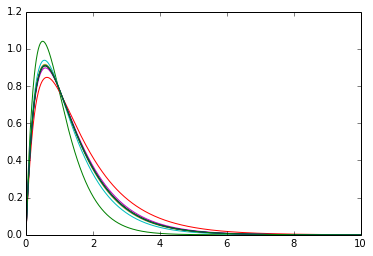

In [108]:
import matplotlib.pyplot as plt

%matplotlib inline


plt.plot(r,u0);